In [1]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,

    Random,
    StatsBase
;

using Distributions, Interpolations

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_constant_diffusion.jl")
include("CaOH_scan_helper_diffusion.jl")
working_dir = "G:\\My Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
# working_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\repump"
;

In [2]:
package = get_CaOH_package();
package_A = get_CaOH_package_12_A_states();
n_states = length(package.states)
n_excited = package.n_excited;

In [12]:
using MAT

size_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure3\\GradientScan_20240129\\gradient.mat"
size_file = matread(size_file_path);

numbers_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure3\\GradientScan_20240129\\gradient_numbers.mat"
numbers_file = matread(numbers_file_path);
 
temperature_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure3\\GradientScan_Temperature\\temperatures.mat"
temperature_file = matread(temperature_file_path);

simulation_file_path = "X:\\Shared drives\\CaOH exp\\Papers\\CaOH_BlueMOT\\Analysis\\Figure3\\GradientScan_20240129\\simulations_diffusion.mat";

In [5]:
widths_x = size_file["widths_x"];
d_widths_x = size_file["widths_errors_x"];
widths_y = size_file["widths_y"];
d_widths_y = size_file["widths_errors_y"];

data_size = (widths_x.^2 .* widths_y).^(1/3)
d_data_size = sqrt.((2/3 .* d_widths_x ./ widths_x).^2 + (1/3 .* d_widths_y ./ widths_y).^2) .* data_size

data_signal = numbers_file["ampx1"];
d_data_signal = numbers_file["ampx1_errors"];

data_temperature = real.(temperature_file["temps"]);
d_data_temperature = real.(temperature_file["temp_errors"]);

voltages = size_file["all_params"]'

7×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.5
 1.0
 1.5
 2.0
 2.5
 3.0
 3.5

In [6]:
saving_path = "C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_gradient_diffusion1000.jl"

"C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_gradient_diffusion1000.jl"

In [7]:
function find_diffusion_constant(params; run_time=1e-3, n_particles=20, ramp_time=1e-6, temp=1e-4, diameter=80e-6)
    params_copy = deepcopy(params)
    params_copy.n_values = n_particles
    params_copy.B_ramp_time = ramp_time
    params_copy.s_ramp_time = ramp_time
    params_copy.temp = temp
    params_copy.diameter = diameter
    sequence = [params_copy]
    durations = [run_time]
    generate_sequence!(sequence, durations)
    
    results = simulate_particles_diffusion(package, package_A, sequence, variable_budget=true)
    diffusion_constant = plot_average_diffusion(results)
    return diffusion_constant
end;

In [8]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end

temp = @with_unit 1.00 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 

s2 = 0.0; Δ2 = 0.0; B_gradient = 75; ramp_time = 4e-3

detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)

intensity_voltage = 0.9
power_total = intensity_voltage * 13.1/2.2 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4
;


results_list = []

for gradient_voltage in voltages
    
    @printf("gradient voltage = %.1f V", gradient_voltage)
    B_gradient = gradient_voltage / 1.5 * 75
    blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 1000,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,
                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0.0, 

                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 13.3*1e3/(50e-4)^2*0,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,
                                diffusion_constant = 0.0)

    # Find diffusion constant for the current parameters
    diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-3, n_particles=20, 
                                            ramp_time=1e-6, temp = 1e-4, diameter=80e-6)

    blue_MOT_params.diffusion_constant = diffusion_constant
    @printf("Diffusion constant = %.2f \n", diffusion_constant)
    sequence = [blue_MOT_params]
    durations = [ramp_time + 1e-3]
    generate_sequence!(sequence, durations)

    @time results = simulate_particles_constant_diffusion(package, package_A, sequence, variable_budget=true);
    
    push!(results_list, results)
    
    serialize(saving_path, results_list)

    @printf("goodness = %.2f",  goodness(blue_MOT_params.t_end, results))
    
    println()
    println()
end

gradient voltage = 0.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


Diffusion constant = 1.33 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:36


816.499000 seconds (13.24 M allocations: 1.048 GiB, 0.04% gc time, 14.03% compilation time)
Survival: 997 / 1000
goodness = 0.33

gradient voltage = 1.0 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:18
Progress:   3%|██                                       |  ETA: 0:15:26

Diffusion constant = 1.33 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:17


797.338495 seconds (1.65 M allocations: 344.541 MiB, 0.00% gc time)
Survival: 963 / 1000
goodness = 0.48

gradient voltage = 1.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:23


Diffusion constant = 1.28 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:08


788.525251 seconds (1.64 M allocations: 342.433 MiB)
Survival: 903 / 1000
goodness = 0.51

gradient voltage = 2.0 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:21


Diffusion constant = 1.23 


Progress: 100%|█████████████████████████████████████████| Time: 0:13:01


781.207675 seconds (1.64 M allocations: 341.377 MiB)
Survival: 867 / 1000
goodness = 0.49

gradient voltage = 2.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:22


Diffusion constant = 1.21 


Progress: 100%|█████████████████████████████████████████| Time: 0:12:16


736.593566 seconds (1.64 M allocations: 338.470 MiB)
Survival: 762 / 1000
goodness = 0.44

gradient voltage = 3.0 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:24


Diffusion constant = 1.17 


Progress: 100%|█████████████████████████████████████████| Time: 0:11:50


710.126837 seconds (1.64 M allocations: 337.351 MiB)
Survival: 713 / 1000
goodness = 0.42

gradient voltage = 3.5 V

Progress: 100%|█████████████████████████████████████████| Time: 0:03:12


Diffusion constant = 1.13 


Progress: 100%|█████████████████████████████████████████| Time: 0:11:37

697.099192 seconds (1.63 M allocations: 334.648 MiB, 0.00% gc time)


Survival: 640 / 1000
goodness = 0.38



In [10]:
# serialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_single_det2000.jl", results_list)

In [7]:
# results_list = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_gradient2000.jl");
# results_list_imperfection = deserialize("C:\\Users\\halla\\OneDrive\\Desktop\\blueMOT_sim\\parameter_scans\\scan_gradient_imperfection2000.jl");

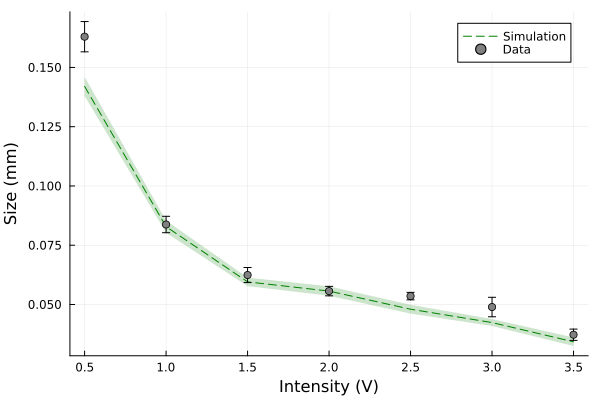

In [9]:
sizes = []
size_errors = []
for results in results_list[1:end]
    size, error = bootstrap_size_fit(results; iter=100)
    push!(sizes, size)
    push!(size_errors, error)
end

plot(voltages, sizes,color="green",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation",
ribbon=(size_errors, size_errors),fc=:green,fa=0.2)

# sizes1 = []
# size1_errors = []
# for results in results_list_imperfection[1:end]
#     size, error = bootstrap_size_fit(results; iter=100)
#     push!(sizes1, size)
#     push!(size1_errors, error)
# end

# plot!(voltages, sizes1,color="red",linestyle=:dash, xlabel="Intensity (V)", ylabel="Size (mm)",label="Simulation with imperfection",
# ribbon=(size1_errors, size1_errors),fc=:red,fa=0.2)

scatter!(voltages, data_size, yerr=d_data_size, label="Data", color="gray")

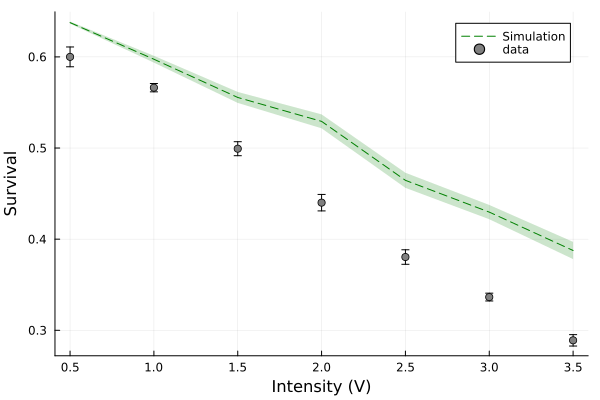

In [10]:
signals = []
signal_errors = []

for results in results_list[1:end]
    signal, error = bootstrap_survival(results, iter=100)
    push!(signals, signal)
    push!(signal_errors, error)
end
    
plot(voltages, signals,color="green", linestyle=:dash, xlabel="Intensity (V)", ylabel="Survival",label="Simulation",
ribbon=(signal_errors, signal_errors),fc=:green,fa=0.2)



# signals1 = []
# signal1_errors = []
# for results in results_list_imperfection[1:end]
#     signal1, error = bootstrap_survival(results; iter=100)
#     push!(signals1, signal1)
#     push!(signal1_errors, error)
# end

# plot!(voltages, signals1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(signal1_errors, signal1_errors),fc=:red,fa=0.2)
scatter!(voltages, data_signal./maximum(data_signal)*0.6, yerr=d_data_signal, color="gray", label="data")

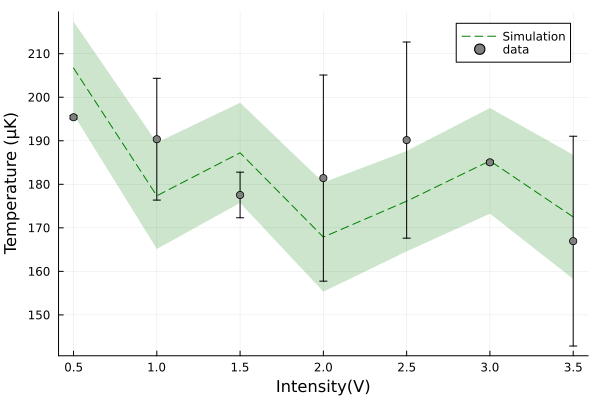

In [11]:
temperatures = []
temperature_errors = []
t_end = 5e-3

for results in results_list[1:end]
    temp, error = bootstrap_temperature_fit(results, iter=100)
    push!(temperatures, temp)
    push!(temperature_errors, error)
end
    
plot(voltages, temperatures,color="green",linestyle=:dash, xlabel="Intensity(V)", ylabel="Temperature (μK)",label="Simulation",
ribbon=(temperature_errors, temperature_errors),fc=:green,fa=0.2)



# temperatures1 = []
# temperature1_errors = []
# for results in results_list_imperfection[1:end]
#     temp, error = bootstrap_temperature_fit(results; iter=100)
#     push!(temperatures1, temp)
#     push!(temperature1_errors, error)
# end

# plot!(voltages, temperatures1,color="red",linestyle=:dash, label="Simulation with imperfection",
# ribbon=(temperature1_errors, temperature1_errors),fc=:red,fa=0.2)


scatter!(voltages, data_temperature.*1e6, yerr=d_data_temperature.*1e6, color="gray", label="data")

In [13]:
file = matopen(simulation_file_path, "w")
write(file, "simulation_sizes", sizes)
write(file, "simulation_size_errors", size_errors)

write(file, "simulation_signals", signals)
write(file, "simulation_signal_errors", signal_errors)

write(file, "simulation_temperatures", temperatures)
write(file, "simulation_temperature_errors", temperature_errors)

# write(file, "simulation_sizes_imperfection", sizes1)
# write(file, "simulation_size_errors_imperfection", size1_errors)

# write(file, "simulation_signals_imperfection", signals1)
# write(file, "simulation_signal_errors_imperfection", signal1_errors)

# write(file, "simulation_temperatures_imperfection", temperatures1)
# write(file, "simulation_temperature_errors_imperfection", temperature1_errors)
close(file);